# Predicting Meteoroid Conditions

## Preliminar

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid
from tqdm import tqdm
from scipy.stats import linregress
from glob import glob
from datetime import datetime
%matplotlib nbagg

#Routines
def ipercs(xs,ps,qpercs):
    """
    Compute percentiles from a numerical normalized distribution ps
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

#Routines to convert from local to body systems and viceversa
def loc2rec(vp,distance,Az,h):
    """
    Convert distance, azimuth and elevation to position w.r.t. Earth
    vp (dictionary): Vantage point.  It should have: lon, lat, alt
    distance: km
    Az: deg
    h: deg
    """
    rlocal=spy.latrec(distance,Az*DEG,h*DEG)
    rpos=spy.mxv(vp["l2b"],rlocal)+vp["geopos"]
    return rpos


def rec2loc(vp,rpos):
    """
    Convert position w.r.t. Earth to distance, Azimuth and elevation
    distance: km
    Az: deg
    h: deg
    """
    rrel=rpos-vp["geopos"]
    rlocal=spy.mxv(vp["b2l"],rrel)
    distance,Az,h=spy.reclat(rlocal)
    Az=2*np.pi+Az if Az<0 else Az
    return distance,Az*RAD,h*RAD

def updateVantagePoint(vp):
    """
    Compute related geometrical properties of a vantage point
    """
    vp["geopos"]=spy.georec(vp["lon"]*DEG,vp["lat"]*DEG,vp["alt"],RE,F)
    normal=spy.surfnm(RE,RE,RP,vp["geopos"])
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    vp["l2b"]=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    vp["b2l"]=np.linalg.inv(vp["l2b"])

### SPICE specifics

In [9]:
BDIR="./"
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/earth_070425_370426_predict.bpc")
spy.furnsh(BDIR+"kernels/earth_assoc_itrf93.tf")
#Astronomical constants
n,rs=spy.bodvrd("EARTH","RADII",3)
RE=rs[0];RP=rs[2]
F=(RE-RP)/RE

### Macro and Constants

In [10]:
#Directories
FIGDIR=BDIR+"figures/"

#Macros
norm=np.linalg.norm
DEG=np.pi/180
RAD=1/DEG

#Fitting procedure
lengthTestTrajectory=300 #km
npointsTestTrajectory=100

## Impact data

In [4]:
#Read vantage positions position
havana=pd.read_csv("data/havana-observations-final.csv",decimal=",")
florida=pd.read_csv("data/florida-observations-final.csv",decimal=",")
pinar=pd.read_csv("data/pinardelrio-observations-final.csv",decimal=",")

#Build vantage points dictionary
vantagePoints=dict(
    impact=dict(
        location="Impact",
        obstraj=None,
        lon=0,lat=0,alt=0,
        Azref=0.0,
    ),
    havana=dict(
        location="Havana harbor",
        obstraj=havana,
        lon=-82.344343,lat=23.13799,alt=0/1000.,
        Azref=0.0,
    ),
    florida=dict(
        location="GullWing Beach Resort (Florida)",
        obstraj=florida,
        lon=-81.903596,lat=26.418871,alt=1/1000.,
        Azref=201.6,
    ),
    pinar=dict(
        location="Pinar del Rio (Cuba)",
        obstraj=pinar,
        lon=-83.692091,lat=22.414536,alt=48/1000.,
        Azref=0.0,
    ),
)

#Geometrical properties of the vantage point
for key,vp in vantagePoints.items():updateVantagePoint(vp)
nvp=len(vantagePoints.keys())-1

## Chi-square computation

In [5]:
def chiSquare(param,vps,avoid=[],verbose=False,npoints=npointsTestTrajectory):
    
    #Input parameters
    lonProj=param[0] # deg
    latProj=param[1] # deg
    hrad=param[2] #deg 
    Azrad=param[3] #deg
    
    #Impact position
    vantagePoints["impact"]["lon"]=lonProj
    vantagePoints["impact"]["lat"]=latProj
    vantagePoints["impact"]["alt"]=0.0
    updateVantagePoint(vantagePoints["impact"])
    
    #Reference Azimuth in Florida
    vantagePoints["florida"]["Azref"]=param[4]
    
    #Direction of radiant
    r=loc2rec(vps["impact"],1,Azrad,hrad)-vps["impact"]["geopos"]
    uimp,magn=spy.unorm(r)
    
    #Trajectory with this conditions
    trajectory=np.zeros((npoints,3))
    for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
        trajectory[i]=uimp*t+vps["impact"]["geopos"]
        
    #Az,h points of trayectory in vantage point vp
    chi2=0
    for key,vp in vps.items():
        if key=="impact" or key in avoid:continue

        #Compute theoretical trajectory
        vp["theotraj"]=np.zeros((npoints,2))
        for i in range(len(trajectory)):
            rpos=trajectory[i]
            d,Az,h=rec2loc(vp,rpos)
            vp["theotraj"][i]=np.array([Az,h])
        
        #Compute chisquare for this vantage point
        otraj=vp["obstraj"].values
        dAzmat=np.array([((otraj[i,2]+vp["Azref"])-vp["theotraj"][:,0])**2/otraj[i,3]**2 for i in range(len(otraj))])
        dhmat=np.array([(otraj[i,0]-vp["theotraj"][:,1])**2/otraj[i,1]**2 for i in range(len(otraj))])
        dposmat=np.sqrt(dAzmat+dhmat)
        chi=dposmat.min(axis=1).sum()
        chi2+=(dposmat.min(axis=1).sum()) #/len(otraj)
            
    return chi2

### Minimization

      fun: 45.1534979368861
 hess_inv: array([[ 1.71670351e-06, -1.00111326e-07, -1.03792313e-05,
         1.61351811e-04, -3.17774254e-06],
       [-1.00111326e-07,  4.67443537e-08, -2.15792866e-06,
        -7.34944574e-06,  1.24491029e-06],
       [-1.03792313e-05, -2.15792866e-06,  4.09849812e-04,
        -1.29038711e-03, -6.97643557e-05],
       [ 1.61351811e-04, -7.34944574e-06, -1.29038711e-03,
         1.60970549e-02, -1.79930359e-04],
       [-3.17774254e-06,  1.24491029e-06, -6.97643557e-05,
        -1.79930359e-04,  9.11696355e-04]])
      jac: array([-109.76175976,   97.97950315,   -0.98173618,    2.26894808,
         -0.53333664])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 742
      nit: 24
     njev: 105
   status: 2
  success: False
        x: array([-83.78217648,  22.80238773,  33.37718232, 178.66710909,
       192.45847439])

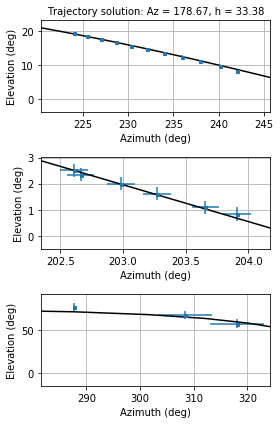

In [6]:
#Minimization
lonProj=-83.7751101
latProj=22.80728391
hrad=33.0 #deg 
Azrad=180.0 #deg
Azref=192.0 #deg
param=[lonProj,latProj,hrad,Azrad,Azref]
solution=minimize(chiSquare,param,args=(vantagePoints,[],False),options=dict(maxiter=100))

#Plot solution
fig,axs=plt.subplots(nvp,figsize=(4,6))
i=-1

for i,ax in enumerate(axs):
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("Elevation (deg)")

axs[0].set_title(f"Trajectory solution: Az = {solution.x[3]:.2f}, h = {solution.x[2]:.2f}",fontsize=10)

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1
    
    #Plot observed points
    axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'k-')
    axs[i].errorbar(vp["obstraj"]["Az"]+vp["Azref"],vp["obstraj"]["h"],
                    xerr=vp["obstraj"]["Azerr"],yerr=vp["obstraj"]["herr"],marker='s',ms=3,ls='')
    #axs[i].text(0.9,0.9,vp["location"],ha='right',va='top',transform=axs[i].transAxes)

    #Ranges
    Azmin=(vp["obstraj"]["Az"]+vp["Azref"]).min();Azmax=(vp["obstraj"]["Az"]+vp["Azref"]).max()
    hmin=0;hmax=vp["obstraj"]["h"].max()
    dAz=(Azmax-Azmin)/5.0
    dh=(hmax-hmin)/5.0
    
    axs[i].set_xlim((Azmin-dAz,Azmax+dAz))
    axs[i].set_ylim((hmin-dh,hmax+dh))
    axs[i].grid()
    
fig.tight_layout()
solution

## Improved plot

In [7]:
param=solution.x
chiSquare(param,vantagePoints,npoints=100)

45.1534979368861

In [8]:
#Trajectory with this conditions
npoints=200

#Direction of radiant
r=loc2rec(vantagePoints["impact"],1,param[3],param[2])-vantagePoints["impact"]["geopos"]
uimp,magn=spy.unorm(r)
trajectory=np.zeros((npoints,3))
for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
    trajectory[i]=uimp*t+vantagePoints["impact"]["geopos"]

for key,vp in vantagePoints.items():
    if key=="impact":continue
    vp["theotraj"]=np.zeros((npoints,2))
    for i in range(len(trajectory)):
        rpos=trajectory[i]
        d,Az,h=rec2loc(vp,rpos)
        vp["theotraj"][i]=np.array([Az,h])

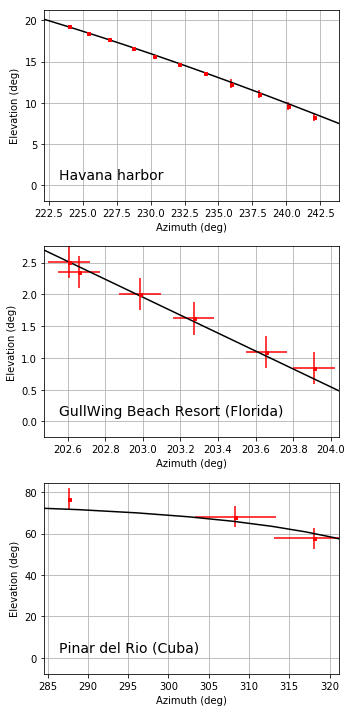

In [9]:
#Plot solution
fig,axs=plt.subplots(nvp,figsize=(5,10))
i=-1

for i,ax in enumerate(axs):
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("Elevation (deg)")

#axs[0].set_title(f"Trajectory solution: Az = {solution.x[3]:.2f}, h = {solution.x[2]:.2f}",fontsize=10)

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1
    
    #Plot observed points
    axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'k-')
    axs[i].errorbar(vp["obstraj"]["Az"]+vp["Azref"],vp["obstraj"]["h"],
                    xerr=vp["obstraj"]["Azerr"],yerr=vp["obstraj"]["herr"],marker='s',ms=3,ls='',color='r')
    axs[i].text(0.05,0.1,vp["location"],ha='left',va='bottom',transform=axs[i].transAxes,fontsize=14)

    #Ranges
    Azmin=(vp["obstraj"]["Az"]+vp["Azref"]).min();Azmax=(vp["obstraj"]["Az"]+vp["Azref"]).max()
    hmin=0;hmax=vp["obstraj"]["h"].max()
    dAz=(Azmax-Azmin)/10.0
    dh=(hmax-hmin)/10.0
    
    axs[i].set_xlim((Azmin-dAz,Azmax+dAz))
    axs[i].set_ylim((hmin-dh,hmax+dh))
    axs[i].grid()
    
fig.savefig(FIGDIR+"trajectory-fit.png")
fig.tight_layout()

### Compute the trajectory and the foot print

In [52]:
#vp=vantagePoints["havana"]
#vp=vantagePoints["florida"]
vp=vantagePoints["pinar"]

In [53]:
#Range of interpolation
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()
Azmax=(vp["obstraj"]["Az"].values+vp["Azref"]).max()

#Traverse the theoretical trajectory
dAzmin_min=1e100
dAzmax_min=1e100
imin=0;imax=0
for i in range(len(trajectory)):
    rpos=trajectory[i]
    d,Az,h=rec2loc(vp,rpos)
    dAzmin=np.abs(Az-(Azmin))
    dAzmax=np.abs(Az-(Azmax))
    if dAzmin<=dAzmin_min:
        imin=i
        dAzmin_min=dAzmin
    if dAzmax<=dAzmax_min:
        imax=i
        dAzmax_min=dAzmax
trajectory_sel=trajectory[imax:imin]
len(trajectory_sel)

5

In [54]:
traj=trajectory_sel
#traj=trajectory
trajectory_geo=[]
for i,point in enumerate(traj):
    lon,lat,alt=spy.recgeo(point,RE,F)
    if alt>80:break
    trajectory_geo+=[[lon*RAD,lat*RAD,alt]]
trajectory_geo=np.array(trajectory_geo)

In [55]:
trajectory_geo

array([[-83.77451966,  22.49661362,  22.48369051],
       [-83.77423775,  22.48532995,  23.31989162],
       [-83.77395597,  22.47404923,  24.15633978],
       [-83.7736743 ,  22.46277145,  24.99303489],
       [-83.77339275,  22.45149662,  25.82997686]])

In [14]:
f=open(BDIR+"data/cuba-trajectory-Zuluaga_et_al_2019.kml","w")
f.write("""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>Cuba Meteor Trajectory, Zuluaga et al. (2019)</name>
	<Style id="sh_ylw-pushpin">
		<IconStyle>
			<scale>1.3</scale>
			<Icon>
				<href>http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png</href>
			</Icon>
			<hotSpot x="20" y="2" xunits="pixels" yunits="pixels"/>
		</IconStyle>
		<BalloonStyle>
		</BalloonStyle>
		<LineStyle>
			<color>ff1bffd9</color>
			<width>1.5</width>
		</LineStyle>
	</Style>
	<StyleMap id="msn_ylw-pushpin">
		<Pair>
			<key>normal</key>
			<styleUrl>#sn_ylw-pushpin</styleUrl>
		</Pair>
		<Pair>
			<key>highlight</key>
			<styleUrl>#sh_ylw-pushpin</styleUrl>
		</Pair>
	</StyleMap>
	<Style id="sn_ylw-pushpin">
		<IconStyle>
			<scale>1.1</scale>
			<Icon>
				<href>http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png</href>
			</Icon>
			<hotSpot x="20" y="2" xunits="pixels" yunits="pixels"/>
		</IconStyle>
		<BalloonStyle>
		</BalloonStyle>
		<LineStyle>
			<color>ff1bffd9</color>
			<width>1.5</width>
		</LineStyle>
	</Style>
	<Placemark>
		<name>Trajectory</name>
		<styleUrl>#msn_ylw-pushpin</styleUrl>
		<LineString>
			<tessellate>1</tessellate>
			<altitudeMode>relativeToGround</altitudeMode>
			<coordinates>
""")

for point in trajectory_geo:
    f.write(f"				{point[0]},{point[1]},{point[2]*1000}\n")
        
f.write("""
			</coordinates>
		</LineString>
	</Placemark>
	<Placemark>
		<name>Polygon</name>
		<styleUrl>#msn_ylw-pushpin</styleUrl>
		<Polygon>
			<altitudeMode>relativeToGround</altitudeMode>
			<outerBoundaryIs>
				<LinearRing>
					<coordinates>
""")

f.write(f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},0\n")
for point in trajectory_geo:
    f.write(f"				{point[0]},{point[1]},{point[2]*1000}\n")
f.write(f"				{trajectory_geo[-1,0]},{trajectory_geo[-1,1]},0\n")
f.write(f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},0\n")

f.write("""
				</coordinates>
				</LinearRing>
			</outerBoundaryIs>
		</Polygon>
	</Placemark>
</Document>
</kml>
""")
f.close()

## Velocity

In [15]:
vp=vantagePoints["havana"]
vp["obstraj"]

,h,herr,Az,Azerr,t
0,19.334099,0.076119,223.972370,0.019030,0.0
1,18.458736,0.076119,225.418621,0.019030,0.5
2,17.697091,0.076777,226.941452,0.019194,1.0
3,16.688819,0.075858,228.670378,0.018965,1.5
4,15.626803,0.075858,230.263402,0.018965,2.0
5,14.728930,0.076119,232.117050,0.019030,2.5
6,13.578630,0.075858,233.980457,0.018965,3.0
7,12.326968,0.493079,235.914842,0.018965,3.5
8,11.037572,0.491399,237.985760,0.018900,4.0
9,9.617560,0.492237,240.094814,0.018932,4.5


In [16]:
#Range of interpolation
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()
Azmax=(vp["obstraj"]["Az"].values+vp["Azref"]).max()
tmin=vp["obstraj"]["t"].min()
tmax=vp["obstraj"]["t"].max()

i_ini=0;i_end=10
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"])[i_ini]
Azmax=(vp["obstraj"]["Az"].values+vp["Azref"])[i_end]
tmin=vp["obstraj"]["t"][i_ini]
tmax=vp["obstraj"]["t"][i_end]

#Traverse the theoretical trajectory
dAzmin_min=1e100
dAzmax_min=1e100
imin=0;imax=0
for i in range(len(trajectory)):
    rpos=trajectory[i]
    d,Az,h=rec2loc(vp,rpos)
    dAzmin=np.abs(Az-(Azmin))
    dAzmax=np.abs(Az-(Azmax))
    if dAzmin<=dAzmin_min:
        imin=i
        dAzmin_min=dAzmin
    if dAzmax<=dAzmax_min:
        imax=i
        dAzmax_min=dAzmax
trajectory_sel=trajectory[imax:imin]

### Interpolate points in trajectory

In [58]:
vp=vantagePoints["havana"]

#Build fulltrajectory
fulltrajectory=np.concatenate((trajectory,vp["theotraj"]),axis=1)

#Interpolate positions
xfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,0])
yfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,1])
zfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,2])

#Calculate distance cover between observed points
spoints=np.zeros((len(vp["obstraj"]),5))
for i,point in enumerate(vp["obstraj"].values):
    Az=point[2]
    t=point[4]
    intpoint=[float(xfunc(Az)),float(yfunc(Az)),float(zfunc(Az))]
    if i==0:
        distance=0
    else:
        distance=norm(intpoint-spoints[0,:3])
    spoints[i]=np.array(intpoint+[distance,t])
    
#Ranges
tmin=spoints[:,4].min();tmax=spoints[:,4].max()

#Perform linear regression of times and distances
regression=linregress(spoints[:,4],spoints[:,3])
d0=regression.intercept;vimp=regression.slope

<IPython.core.display.Javascript object>


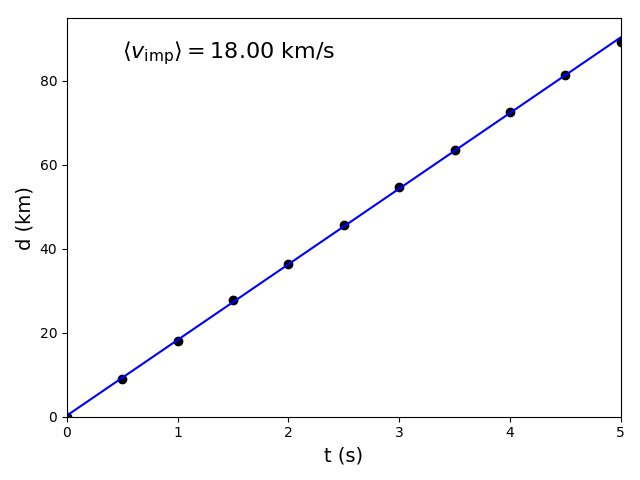

In [59]:
fig=plt.figure()
ax=fig.gca()

ax.plot(spoints[:,4],spoints[:,3],'ko')
ts=np.linspace(tmin,tmax,100)
ax.plot(ts,d0+vimp*ts,'b-')

ax.set_xlabel("t (s)",fontsize=14)
ax.set_ylabel("d (km)",fontsize=14)

ax.text(0.1,0.9,r"$\langle v_{\rm imp}\rangle=%.2f$ km/s"%vimp,transform=ax.transAxes,fontsize=16)

ymin,ymax=ax.get_ylim()
ax.set_xlim((0,tmax))
ax.set_ylim((0,ymax))

fig.tight_layout()
fig.savefig(FIGDIR+"impact-speed.png")

### LaTeX tables

In [19]:
for key,vp in vantagePoints.items():
    if key=="impact":continue
    print("\\hline\\multicolumn{4}{c}{%s}\\\\\\hline"%vp['location']) 
    for i,point in enumerate(vp["obstraj"].values):
        if key=="pinar":t="-"
        else:t=f"{point[4]:.2f}"
        if key=="florida":Az=r"$A_{\rm ref}$"+f"+{point[2]:.1f}"
        else:Az=f"{point[2]:.2f}"
            
        #print(f"{i+1} & %.1f $\pm$ {point[3]:.1g} & {point[0]:.1f} $\pm$ {point[1]:.1g} & {t} \\\\"%(point[2]+vp["Azref"]))
        print(f"{i+1} & {Az} $\pm$ {point[3]:.1g} & {point[0]:.1f} $\pm$ {point[1]:.1g} & {t} \\\\"%(point[2]+vp["Azref"]))

        

\hline\multicolumn{4}{c}{Havana harbor}\\\hline
1 & 223.97 $\pm$ 0.02 & 19.3 $\pm$ 0.08 & 0.00 \\
2 & 225.42 $\pm$ 0.02 & 18.5 $\pm$ 0.08 & 0.50 \\
3 & 226.94 $\pm$ 0.02 & 17.7 $\pm$ 0.08 & 1.00 \\
4 & 228.67 $\pm$ 0.02 & 16.7 $\pm$ 0.08 & 1.50 \\
5 & 230.26 $\pm$ 0.02 & 15.6 $\pm$ 0.08 & 2.00 \\
6 & 232.12 $\pm$ 0.02 & 14.7 $\pm$ 0.08 & 2.50 \\
7 & 233.98 $\pm$ 0.02 & 13.6 $\pm$ 0.08 & 3.00 \\
8 & 235.91 $\pm$ 0.02 & 12.3 $\pm$ 0.5 & 3.50 \\
9 & 237.99 $\pm$ 0.02 & 11.0 $\pm$ 0.5 & 4.00 \\
10 & 240.09 $\pm$ 0.02 & 9.6 $\pm$ 0.5 & 4.50 \\
11 & 242.04 $\pm$ 0.02 & 8.3 $\pm$ 0.5 & 5.00 \\
\hline\multicolumn{4}{c}{GullWing Beach Resort (Florida)}\\\hline
1 & $A_{\rm ref}$+10.1 $\pm$ 0.1 & 2.5 $\pm$ 0.3 & 0.44 \\
2 & $A_{\rm ref}$+10.2 $\pm$ 0.1 & 2.3 $\pm$ 0.3 & 0.50 \\
3 & $A_{\rm ref}$+10.5 $\pm$ 0.1 & 2.0 $\pm$ 0.3 & 0.81 \\
4 & $A_{\rm ref}$+10.8 $\pm$ 0.1 & 1.6 $\pm$ 0.3 & 0.94 \\
5 & $A_{\rm ref}$+11.2 $\pm$ 0.1 & 1.1 $\pm$ 0.3 & 1.94 \\
6 & $A_{\rm ref}$+11.5 $\pm$ 0.1 & 0.8 $\pm$ 

### Generate initial conditions for gravitational ray tracing

In [20]:
#Solution
lon=-83.78217648;dlonp=+0.05;dlonm=-0.05
lat=22.80238773;dlatp=+0.05;dlatm=-0.05
Azrad=179;dAzradp=+1.0;dAzradm=-5.0
hrad=33;dhradp=+0.5;dhradm=-1.5
vimp=18.0;dvimpp=+0.3;dvimpm=-1.2

In [21]:
#Generate GRT files
N=10

#Velocities
f=open("data/velocities.dat.cuba_error","w")
vmax=vimp+dvimpp
vmin=vimp+dvimpm
for i in range(N):
    v=vmin+(vmax-vmin)*np.random.rand()
    f.write(f"{v}\t-1\n")
f.close()

#Directions
f=open("data/directions.dat.cuba_error","w")
Azradmax=Azrad+dAzradp
Azradmin=Azrad+dAzradm
hradmax=hrad+dhradp
hradmin=hrad+dhradm
for i in range(N):
    Az=Azradmin+(Azradmax-Azradmin)*np.random.rand()
    h=hradmin+(hradmax-hradmin)*np.random.rand()
    f.write(f"-1\t-1\t{Az}\t{h}\n")
f.close()

#Locations
f=open("data/locations.dat.cuba_error","w")
lonmax=lon+dlonp
lonmin=lon+dlonm
latmax=lat+dlatp
latmin=lat+dlatm
for i in range(N):
    lon=lonmin+(lonmax-lonmin)*np.random.rand()
    lat=latmin+(latmax-latmin)*np.random.rand()
    f.write(f"-1\t-1\t{lon}\t{lat}\n")
f.close()

In [22]:
#After running the GRT read all rays
direrror="data/grt-Cuba_error-20190201181700-BE1E80/"
for i,physfile in enumerate(glob(f"{direrror}/*.phys")):
    data=np.loadtxt(physfile)
    if i==0:
        alldata=data
    else:
        alldata=np.concatenate((alldata,data),axis=0)

#Compute semimajor axis, period and Tisserand parameter
aes=alldata[:,9]/(1-alldata[:,10])
Ps=aes**1.5
Tps=1/aes+2*np.cos(alldata[:,11]*DEG)*np.sqrt(aes*(1-alldata[:,10]**2))
alldata=np.column_stack((alldata,aes,Ps,Tps))
#alldata=np.append(alldata,Ps)
#alldata=np.append(alldata,Tps)
        
#Perform analysis
percentiles=np.percentile(alldata,[15,50,85],axis=0)

In [23]:
props=[
    dict(
        name="a",
        symbol="a",
        units="AU",
        ind=16,
    ),
    dict(
        name="q",
        symbol="q",
        units="AU",
        ind=9,
    ),
    dict(
        name="e",
        symbol="e",
        units="AU",
        ind=10,
    ),
    dict(
        name="i",
        symbol="i",
        units="AU",
        ind=11,
    ),
    dict(
        name="W",
        symbol="\Omega",
        units="AU",
        ind=12,
    ),
    dict(
        name="o",
        symbol="\omega",
        units="AU",
        ind=13,
    ),
    dict(
        name="P",
        symbol="P",
        units="yr",
        ind=17,
    ),
    dict(
        name="Tp",
        symbol="T_p",
        units="adim.",
        ind=18,
    ),
]
for prop in props:
    name=prop["name"]
    pmin,pmed,pmax=percentiles[:,prop["ind"]]
    dpp=pmax-pmed;dpm=pmed-pmin
    print(f"{name} = {pmed:.2f}, d{name} = {(dpp+dpm)/2:.2g},")

a = 1.32, da = 0.062,
q = 0.75, dq = 0.018,
e = 0.44, de = 0.023,
i = 11.68, di = 0.39,
W = 132.54, dW = 0.0033,
o = 283.77, do = 4.1,
P = 1.52, dP = 0.11,
Tp = 2.78, dTp = 0.02,


In [24]:
for prop in props:
    name=prop["name"]
    pmin,pmed,pmax=percentiles[:,prop["ind"]]
    dpp=pmax-pmed;dpm=pmed-pmin
    print(f"${prop['symbol']}$ ({prop['units']}) & ${pmed:.2f}^"+"{"+f"+{dpp:.2g}"+"}_{"+f"-{dpm:.2g}"+"}$\\\\")

$a$ (AU) & $1.32^{+0.06}_{-0.063}$\\
$q$ (AU) & $0.75^{+0.015}_{-0.02}$\\
$e$ (AU) & $0.44^{+0.022}_{-0.024}$\\
$i$ (AU) & $11.68^{+0.41}_{-0.38}$\\
$\Omega$ (AU) & $132.54^{+0.0037}_{-0.003}$\\
$\omega$ (AU) & $283.77^{+3.1}_{-5.1}$\\
$P$ (yr) & $1.52^{+0.1}_{-0.11}$\\
$T_p$ (adim.) & $2.78^{+0.02}_{-0.02}$\\


### Mass and size of the rock

In [60]:
KTON=4.184e12 #J

#Estimated airburst energy
E=1.4*KTON #according to NASA Fireball database

#Luminous efficiency
eta=0.1

In [61]:
#Kinetic energy
K=E/eta

In [62]:
#Mass
M=2*K/(vimp*1e3)**2
print(f"Mass of the impactor: {M/1000:.0f} tons")

#Estimated density
rho=2600 #kg/m^2

#Diameter
D=2*(3*M/(4*np.pi*rho))**(1/3)
print(f"Diameter of the impactor: {D:.0f} m")

Mass of the impactor: 362 tons
Diameter of the impactor: 6 m


## Analysis of Bolide Database

In [5]:
data=pd.read_csv("data/cneos_fireball_data.csv")
datadir=data[data["Calculated Total Impact Energy (kt)"]>1].dropna().sort_values(by="Calculated Total Impact Energy (kt)",ascending=[False]).reset_index(drop=True)
datadir

,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt)
0,2013-02-15 03:20:33,54.8N,61.1E,23.3,18.6,12.8,-13.3,-2.4,3.750000e+14,440.0
1,2010-12-25 23:24:00,38.0N,158.0E,26.0,18.1,18.0,-2.0,-4.0,2.000000e+13,33.0
2,2009-10-08 02:57:00,4.2S,120.6E,19.1,19.2,14.0,-16.0,-6.0,2.000000e+13,33.0
3,2009-11-21 20:53:00,22.0S,29.2E,38.0,32.1,3.0,-17.0,27.0,1.000000e+13,18.0
4,2004-10-07 13:14:43,27.3S,71.5E,35.0,19.2,-15.3,1.0,11.6,1.040000e+13,18.0
5,2006-12-09 06:31:12,26.2N,26.0E,26.5,15.9,4.9,-15.0,1.6,7.410000e+12,14.0
6,2010-07-06 23:54:43,34.1S,174.5W,26.0,15.7,12.1,10.0,0.2,7.560000e+12,14.0
7,2016-02-06 13:55:09,30.4S,25.5W,31.0,15.6,2.7,14.5,5.0,6.853000e+12,13.0
8,2013-04-30 08:40:38,35.5N,30.7W,21.2,12.1,1.0,9.0,-8.0,5.110000e+12,10.0
9,2014-08-23 06:29:41,61.7S,132.6E,22.2,16.2,-2.3,5.7,16.5,3.819000e+12,7.6


### Generate initial conditions

In [6]:
!rm -r data/fireballs/*

In [7]:
f=open("data/fireballs/fireball-impact.sh","w")
datadir["Az"]=0
datadir["h"]=0
for i,ind in enumerate(datadir.index):
    bolide=datadir.iloc[ind]
    dateandtime=datetime.strptime(bolide["Peak Brightness Date/Time (UT)"],"%Y-%m-%d %H:%M:%S").strftime("%m/%d/%Y %H:%M:%S")
    
    #Position
    fb=open(f"data/fireballs/locations.dat.fireball{i:02d}","w")
    lat=bolide["Latitude (deg.)"]
    lon=bolide["Longitude (deg.)"]
    alt=bolide["Altitude (km)"]
    if "N" in lat:
        lat=+float(lat.replace("N",""))
    elif "S" in lat:
        lat=-float(lat.replace("S",""))
    if "E" in lon:
        lon=+float(lon.replace("E",""))
    elif "W" in lon:
        lon=-float(lon.replace("W",""))

    #Script
    f.write(f"python makeagravray.py '{dateandtime} UTC' deg fireballs/locations.dat.fireball{i:02d} rad util/data/directions-r1.50e+01.data 0 util/data/velocities.earth.regular50.dat 'Fireball_{i:02d}' {alt*1000}\n")
    
    #Vantage point
    vp=dict(lat=lat,lon=lon,alt=alt)
    updateVantagePoint(vp)
    vimp=-np.array(bolide[["vx","vy","vz"]].values).astype("float64")
    uimp=vimp/norm(vimp)

    #Convert from earth to local
    r,Az,h=rec2loc(vp,uimp)
    datadir.loc[ind,"Az"]=Az
    datadir.loc[ind,"h"]=h
    
    #Save location
    fb.write(f"-1\t-1\t{lon}\t{lat}\n")
    fb.close()
    
f.close()

NameError: name 'DEG' is not defined

In [1]:
datadir

NameError: name 'datadir' is not defined